In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.signal import welch
from antropy import sample_entropy

# 数据选择

In [2]:
# 选择文件索引
file_index = 10

# 使用MNE库读取EDF格式的EEG原始数据
# 同时读取包含睡眠阶段标注的CSV文件
raw = mne.io.read_raw_edf(f"{file_index}.edf", preload=True, verbose=False)
annotations = pd.read_csv(f"{file_index}.csv")

# 预处理

In [3]:
# 带通滤波(0.5-45Hz): 去除极低频和高频噪声
# 陷波滤波(50Hz及其谐波): 去除电源线干扰
# 降采样至100Hz: 减少数据量，提高处理速度
raw.filter(0.5, 45, fir_design="firwin", verbose=False)
raw.notch_filter(np.arange(50, 251, 50), fir_design="firwin", verbose=False)
raw.resample(100)

# 将连续EEG数据分成30秒的片段(epochs)
# 设置15秒重叠(overlap)确保不丢失边界信息
# 每个epoch包含30秒数据，对应3000个采样点(100Hz采样率)
events = mne.make_fixed_length_events(raw, duration=30, overlap=15)
epochs = mne.Epochs(raw, events, tmin=0, tmax=30, baseline=None, preload=True, verbose=False)

# 根据时间戳添加对应的睡眠阶标签
def get_sleep_stage(onset_time, annotations):
    for i in range(len(annotations) - 1):
        if onset_time >= annotations["Onset"].iloc[i] and onset_time < annotations["Onset"].iloc[i + 1]:
            return annotations["Annotation"].iloc[i]
    return annotations["Annotation"].iloc[-1]

epochs.metadata = pd.DataFrame({"stage": [get_sleep_stage(e[0] / raw.info["sfreq"], annotations) for e in events]})

Adding metadata with 1 columns


# 特征提取

In [4]:
features = []
for i, epoch in enumerate(epochs):
    # epoch: (频道数, 该时段采样数)
    data = epoch * 1e6  # 转换为μV
    stage = epochs.metadata["stage"].iloc[i]

    # 使用Welch方法计算功率谱密度(PSD)
    freqs, psd = welch(data, fs=100, nperseg=256)

    # 计算四个经典频段的相对功率
    #   δ波(0.5-4Hz)：慢波睡眠特征
    #   θ波(4-8Hz)：浅睡眠特征
    #   α波(8-13Hz)：安静清醒特征
    #   β波(13-30Hz)：活跃认知特征
    delta = trapezoid(psd[:, (freqs >= 0.5) & (freqs < 4)], freqs[(freqs >= 0.5) & (freqs < 4)])
    theta = trapezoid(psd[:, (freqs >= 4) & (freqs < 8)], freqs[(freqs >= 4) & (freqs < 8)])
    alpha = trapezoid(psd[:, (freqs >= 8) & (freqs < 13)], freqs[(freqs >= 8) & (freqs < 13)])
    beta = trapezoid(psd[:, (freqs >= 13) & (freqs < 30)], freqs[(freqs >= 13) & (freqs < 30)])
    total = delta + theta + alpha + beta
    rel_delta = delta / total
    rel_theta = theta / total
    rel_alpha = alpha / total
    rel_beta = beta / total

    # 计算计算样本熵(Sample Entropy)
    sampen = np.array([sample_entropy(data[j, :], order=2, metric="chebyshev") for j in range(data.shape[0])])

    # 计算时域特征
    # 峰峰值(Peak-to-peak): 最大最小值差
    ptp = np.ptp(data, axis=1)
    # 均方根(Root Mean Square): 信号能量指标
    rms = np.sqrt(np.mean(data**2, axis=1))

    # 记录特征
    for ch_idx, ch in enumerate(raw.ch_names):
        features.append(
            {
                "channel": ch,
                "stage": stage,
                "delta": rel_delta[ch_idx],
                "theta": rel_theta[ch_idx],
                "alpha": rel_alpha[ch_idx],
                "beta": rel_beta[ch_idx],
                "sampen": sampen[ch_idx],
                "ptp": ptp[ch_idx],
                "rms": rms[ch_idx],
            }
        )

features_df = pd.DataFrame(features)

# 特征可视化

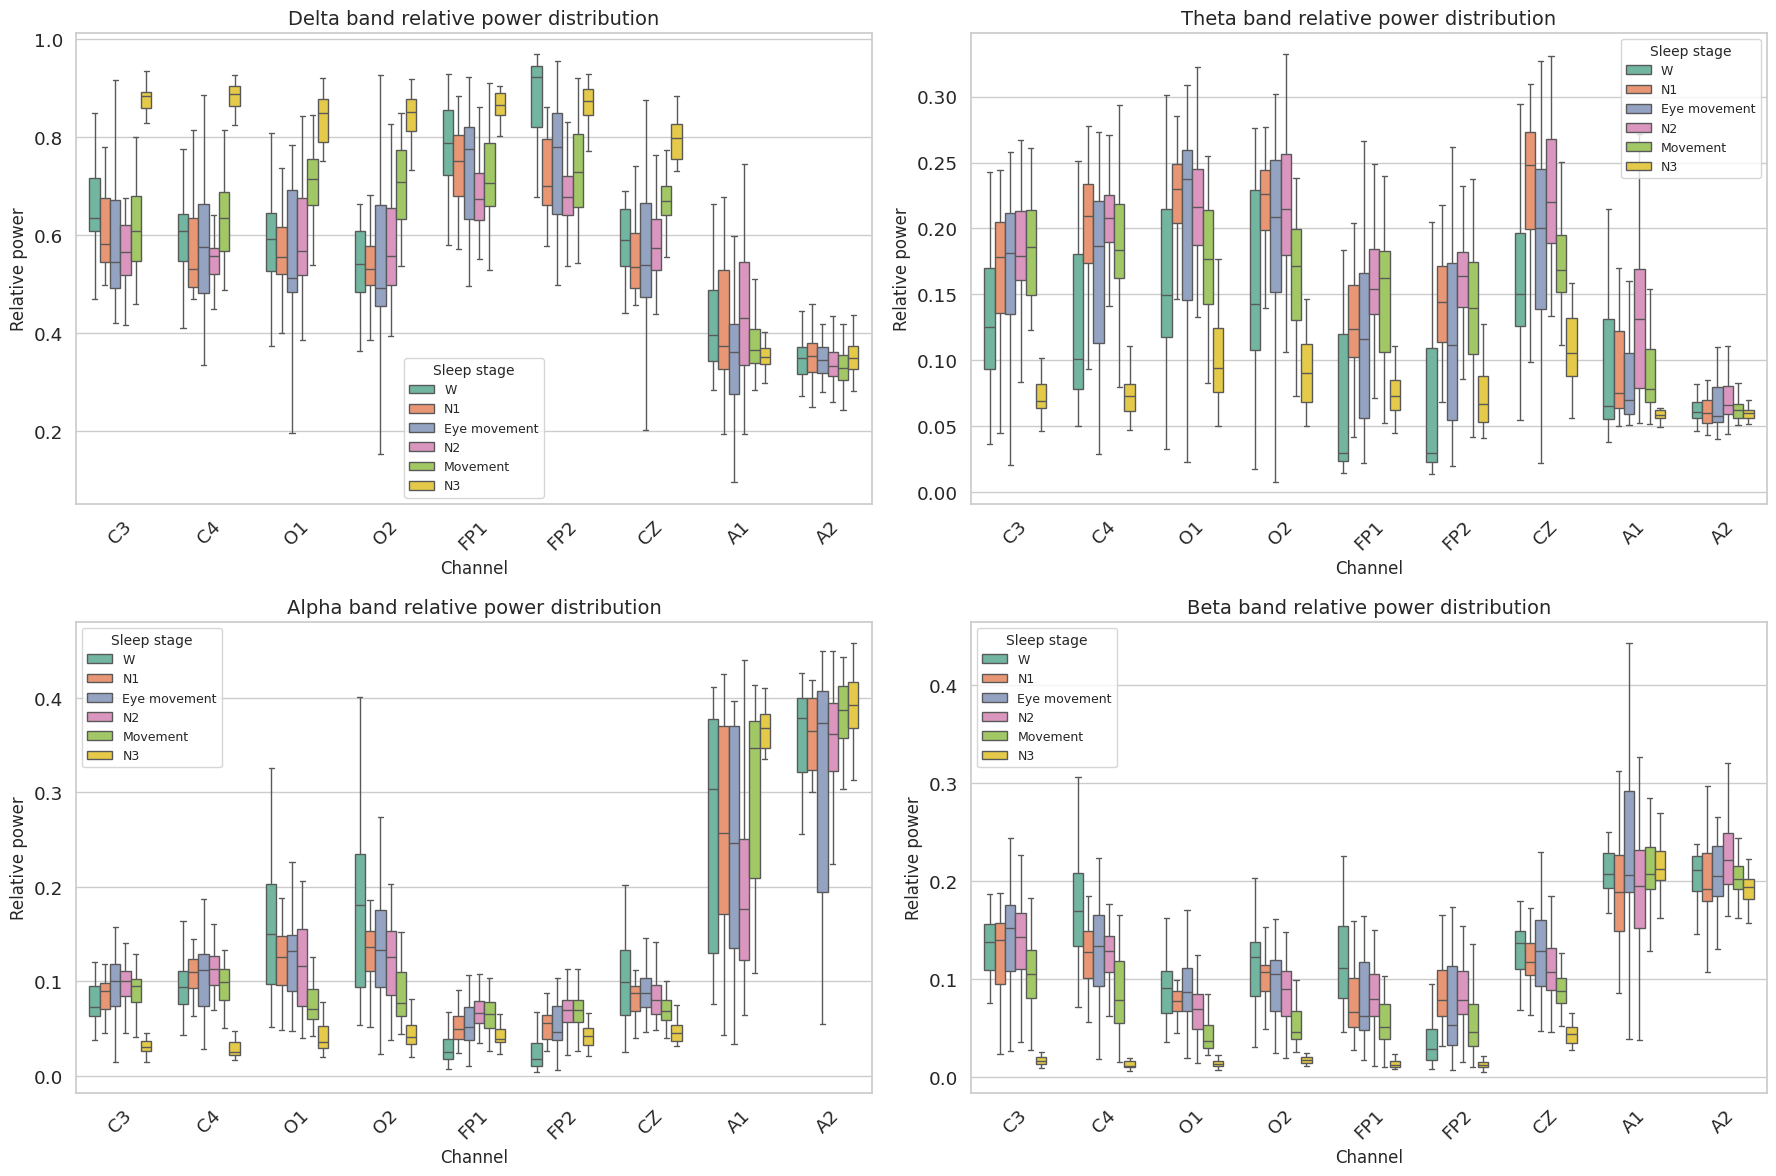

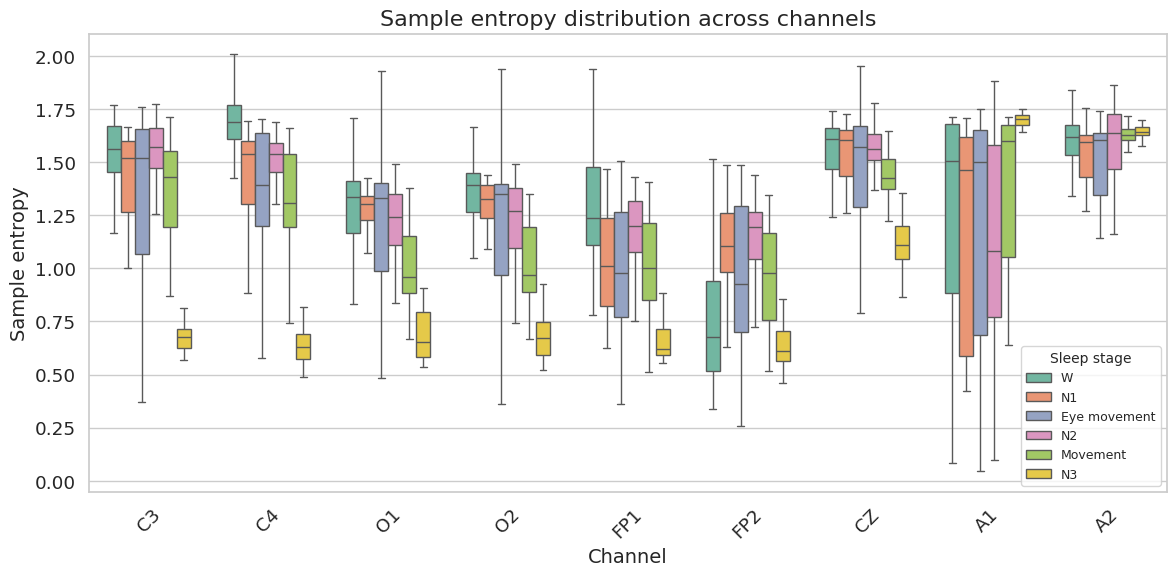

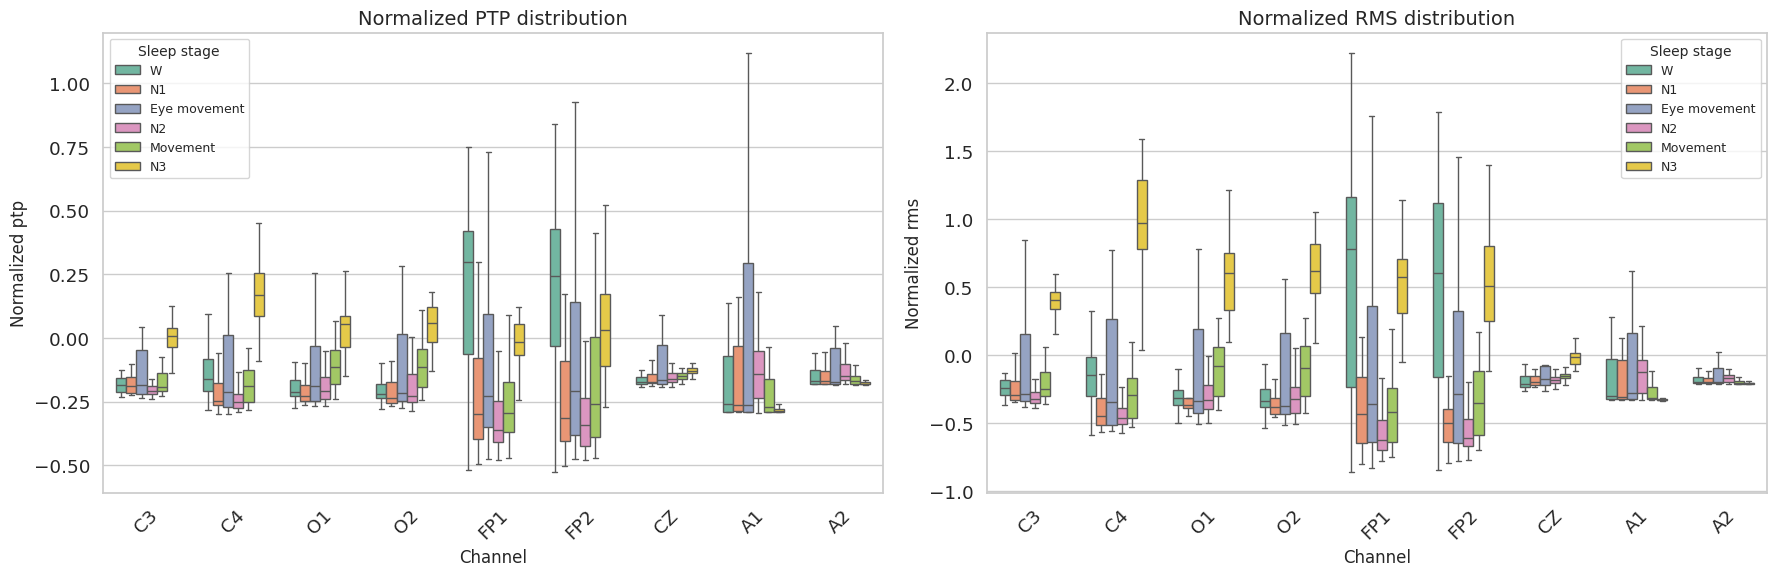

In [10]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(18, 12))
bands = ["delta", "theta", "alpha", "beta"]

# 绘制频段功率分布箱线图
for i, band in enumerate(bands):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(
        x="channel",
        y=band,
        hue="stage",
        data=features_df,
        order=raw.ch_names,
        hue_order=annotations["Annotation"].unique().tolist(),
        palette="Set2",
        width=0.7,
        showfliers=False,
    )
    plt.title(f"{band.capitalize()} band relative power distribution", fontsize=14)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Relative power", fontsize=12)
    plt.legend(title="Sleep stage", title_fontsize=10, fontsize=9)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 绘制样本熵分布箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="channel",
    y="sampen",
    hue="stage",
    data=features_df,
    order=raw.ch_names,
    hue_order=annotations["Annotation"].unique().tolist(),
    palette="Set2",
    width=0.7,
    showfliers=False,
)
plt.title("Sample entropy distribution across channels", fontsize=16)
plt.xlabel("Channel", fontsize=14)
plt.ylabel("Sample entropy", fontsize=14)
plt.legend(title="Sleep stage", title_fontsize=10, fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 绘制时域特征分布箱线图
# 计算每个通道的z-score标准化
features_df_norm = features_df.copy()
for ch in raw.ch_names:
    for feature in ["ptp", "rms"]:
        mask = features_df["channel"] == ch
        mean = features_df.loc[mask, feature].mean()
        std = features_df.loc[mask, feature].std()
        features_df_norm.loc[mask, feature] = (features_df.loc[mask, feature] - mean)/std

# 绘制标准化后的时域特征分布
plt.figure(figsize=(18, 6))
for i, feature in enumerate(["ptp", "rms"], 1):
    plt.subplot(1, 2, i)
    sns.boxplot(
        x="channel",
        y=feature,
        hue="stage",
        data=features_df_norm,
        order=raw.ch_names,
        hue_order=annotations["Annotation"].unique().tolist(),
        palette="Set2",
        width=0.7,
        showfliers=False,
    )
    plt.title(f"Normalized {feature.upper()} distribution", fontsize=14)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel(f"Normalized {feature}", fontsize=12)
    plt.legend(title="Sleep stage", title_fontsize=10, fontsize=9)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

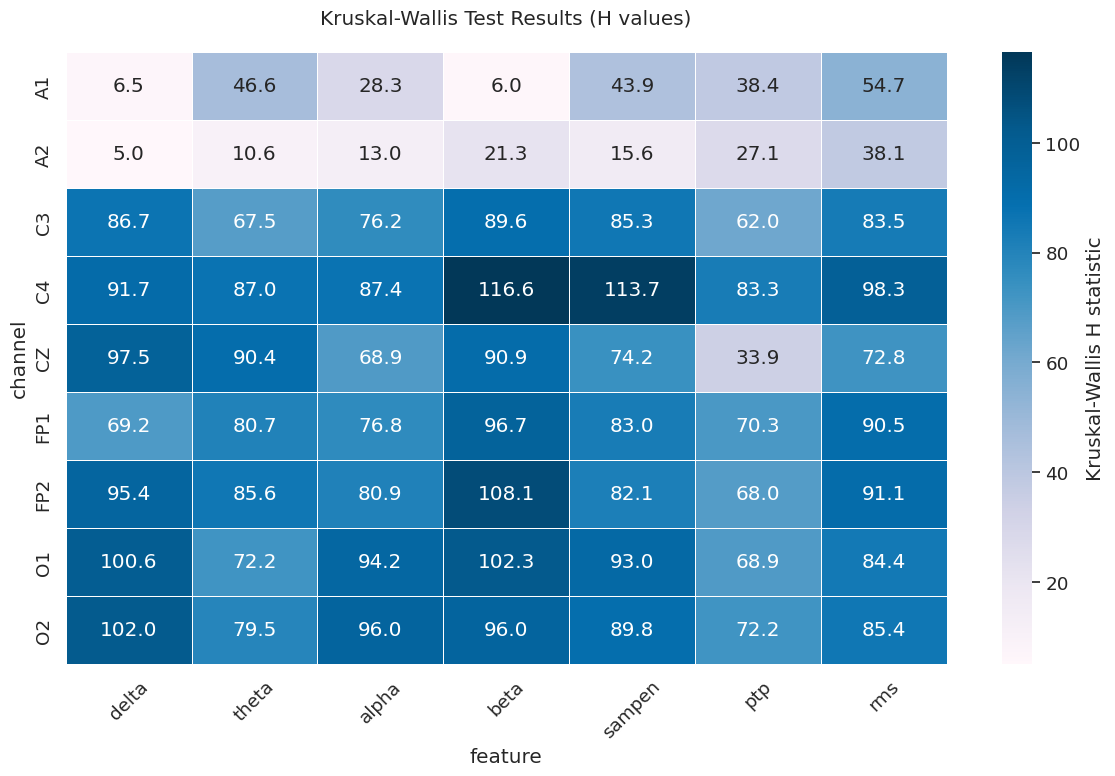

In [31]:
from scipy.stats import kruskal

# Kruskal-Wallis检验可视化
# H值越大表示该特征在该通道对区分睡眠阶段越重要
results = []
for ch in raw.ch_names:
    for feature in ["delta", "theta", "alpha", "beta", "sampen", "ptp", "rms"]:
        groups = [features_df[(features_df["channel"] == ch) & (features_df["stage"] == s)][feature] for s in annotations["Annotation"].unique()]
        h_stat, _ = kruskal(*groups)
        results.append({"channel": ch, "feature": feature, "H": h_stat})
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
heatmap_data = results_df.pivot(index="channel", columns="feature", values="H")[results_df['feature'].unique()]
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="PuBu",
    linewidths=0.5,
    cbar_kws={"label": "Kruskal-Wallis H statistic"},
)
plt.title("Kruskal-Wallis Test Results (H values)", pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()